In [367]:
import pandas as pd

In [368]:
filename = 'cluster_5-trump_ president_ party.json'
path = './lda_clustered_json/'+filename
 
with open(path, encoding='utf-8', mode='r') as currentFile:
    df = pd.read_json(currentFile, orient='index')

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
15,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:42:29",Advertisement Supported by By Michael Wines an...,en,www.nytimes.com,Advertisement Supported by By Michael Wines an...,"In Baring Train Crash Facts, Blogs Erode China...",https://www.nytimes.com/2011/07/29/world/asia/...,5,0.96615,"trump, president, party, obama, force, child, ...",advertisement michael wines sharon lafraniere ...
17,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:37:33",Advertisement Supported by By Matt Flegenheime...,en,www.nytimes.com,Advertisement Supported by By Matt Flegenheime...,'Not Right Now': Republicans and the Art of No...,https://www.nytimes.com/2017/07/11/us/politics...,5,0.95231,"trump, president, party, obama, force, child, ...",advertisement matt flegenheimer emmarie huette...
22,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:02:41","TALLAHASSEE, Fla. The gunman who killed two an...",en,www.usatoday.com,"TALLAHASSEE, Fla. The gunman who killed two an...",Yoga studio gunman was fired as substitute tea...,https://www.usatoday.com/story/news/nation-now...,5,0.95747,"trump, president, party, obama, force, child, ...",tallahassee fla gunman yoga studio substitute ...


In [369]:
amount_of_articles = len(df["filtered_maintext"])
print(f"Amount of articles: {amount_of_articles}")
processed_articles = df['filtered_maintext']

Amount of articles: 168


In [424]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(lowercase=True, stop_words='english', min_df=0.1 , max_df=1.0)  
tfidf = tfidfconverter.fit_transform(processed_articles)
print(tfidf)

  (0, 178)	0.16510178261472422
  (0, 0)	0.08686769445947662
  (0, 273)	0.05842048517123862
  (0, 250)	0.06613466032789336
  (0, 302)	0.07599517523295236
  (0, 304)	0.07316994018979144
  (0, 72)	0.08148672344376544
  (0, 122)	0.07501997933430614
  (0, 337)	0.1222627413034334
  (0, 210)	0.08541788560778871
  (0, 74)	0.08541788560778871
  (0, 5)	0.08541788560778871
  (0, 234)	0.07143934414616714
  (0, 112)	0.07805888030328521
  (0, 77)	0.08686769445947662
  (0, 102)	0.07501997933430614
  (0, 126)	0.08148672344376544
  (0, 200)	0.08148672344376544
  (0, 271)	0.07143934414616714
  (0, 279)	0.06903640022127568
  (0, 167)	0.0647936343102378
  (0, 340)	0.07316994018979144
  (0, 359)	0.08686769445947662
  (0, 223)	0.13509259690338718
  (0, 177)	0.07915351930282188
  :	:
  (167, 165)	0.05928896297765792
  (167, 172)	0.02473643806486945
  (167, 293)	0.022321793869895995
  (167, 117)	0.026880414773697174
  (167, 108)	0.018497496361442725
  (167, 67)	0.043807972579681116
  (167, 269)	0.025014952068

In [425]:
from sklearn.metrics.pairwise import cosine_distances

cosine_similarity = cosine_distances(tfidf)
cosine_similarity

array([[0.        , 0.93533012, 0.96234235, ..., 0.9696557 , 0.92356053,
        0.9594886 ],
       [0.93533012, 0.        , 0.96294129, ..., 0.95065863, 0.85650038,
        0.75317938],
       [0.96234235, 0.96294129, 0.        , ..., 0.98933451, 0.97164605,
        0.96486847],
       ...,
       [0.9696557 , 0.95065863, 0.98933451, ..., 0.        , 0.99180777,
        0.97875305],
       [0.92356053, 0.85650038, 0.97164605, ..., 0.99180777, 0.        ,
        0.88059097],
       [0.9594886 , 0.75317938, 0.96486847, ..., 0.97875305, 0.88059097,
        0.        ]])

In [426]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(convergence_iter=5, affinity='precomputed', random_state=10)
clustering.fit(cosine_similarity)
labels = clustering.labels_
print(labels.dtype)
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

int64


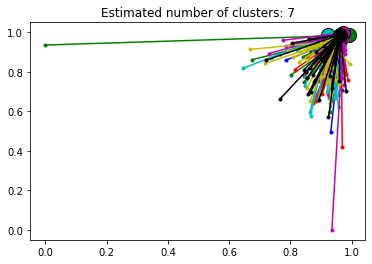

In [427]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [428]:
df['processed_articles'] = processed_articles
df['affpropID'] = clustering.labels_


In [429]:
pd.set_option('max_rows', None)
df

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext,processed_articles,affpropID
15,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:42:29",Advertisement Supported by By Michael Wines an...,en,www.nytimes.com,Advertisement Supported by By Michael Wines an...,"In Baring Train Crash Facts, Blogs Erode China...",https://www.nytimes.com/2011/07/29/world/asia/...,5,0.96615,"trump, president, party, obama, force, child, ...",advertisement michael wines sharon lafraniere ...,advertisement michael wines sharon lafraniere ...,1
17,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:37:33",Advertisement Supported by By Matt Flegenheime...,en,www.nytimes.com,Advertisement Supported by By Matt Flegenheime...,'Not Right Now': Republicans and the Art of No...,https://www.nytimes.com/2017/07/11/us/politics...,5,0.95231,"trump, president, party, obama, force, child, ...",advertisement matt flegenheimer emmarie huette...,advertisement matt flegenheimer emmarie huette...,4
22,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:02:41","TALLAHASSEE, Fla. The gunman who killed two an...",en,www.usatoday.com,"TALLAHASSEE, Fla. The gunman who killed two an...",Yoga studio gunman was fired as substitute tea...,https://www.usatoday.com/story/news/nation-now...,5,0.95747,"trump, president, party, obama, force, child, ...",tallahassee fla gunman yoga studio substitute ...,tallahassee fla gunman yoga studio substitute ...,5
30,"06/30/2021, 22:18:35","06/30/2021, 22:18:35","01/17/2020, 21:48:57","For today, January 17, 2020 UPDATE 3-China reg...",en,www.commoditiesbrokers.com,"For today, January 17, 2020 UPDATE 3-China reg...",Commodity Trading News - Brought to you by Com...,http://www.commoditiesbrokers.com/commodities-...,5,0.81450,"trump, president, party, obama, force, child, ...",update regulator probe stock market margin tra...,update regulator probe stock market margin tra...,3
53,"06/30/2021, 22:19:41","06/30/2021, 22:19:41","01/18/2020, 03:30:36",Troy Guard is opening a new branch of TAG Burg...,en,blogs.denverpost.com,Troy Guard is opening a new branch of TAG Burg...,Beef Archives - The Den,http://blogs.denverpost.com/theden/category/be...,5,0.92477,"trump, president, party, obama, force, child, ...",troy guard branch tag burger bar denver highla...,troy guard branch tag burger bar denver highla...,1
62,"06/30/2021, 22:19:42","06/30/2021, 22:19:42","01/18/2020, 04:35:33","Watch CBSN Live May 10, 2015 / 6:16 PM / CBS/A...",en,www.cbsnews.com,"Watch CBSN Live May 10, 2015 / 6:16 PM / CBS/A...",Indian Point nuclear plant fire sends oil int...,https://www.cbsnews.com/news/indian-point-nucl...,5,0.55481,"trump, president, party, obama, force, child, ...",watch cbsn live cbs ap buchanan power plant tr...,watch cbsn live cbs ap buchanan power plant tr...,6
65,"06/30/2021, 22:19:42","06/30/2021, 22:19:42","01/18/2020, 03:14:04","Live Trump's impeachment By Veronica Rocha, Me...",en,www.cnn.com,"Live Trump's impeachment By Veronica Rocha, Me...",Live updates: Democratic debate in Iowa - CNNP...,https://www.cnn.com/politics/live-news/january...,5,0.54386,"trump, president, party, obama, force, child, ...",live trump impeachment veronica rocha meg wagn...,live trump impeachment veronica rocha meg wagn...,2
69,"06/30/2021, 22:19:42","06/30/2021, 22:19:42","01/18/2020, 03:09:42","Former Rep. Mark Sanford, R-S.C., ended his lo...",en,www.nbcnews.com,"Former Rep. Mark Sanford, R-S.C., ended his l...",Mark Sanford ends long-shot Republican preside...,https://www.nbcnews.com/politics/2020-election...,5,0.97190,"trump, president, party, obama, force, child, ...",former rep mark sanford campaign amount attent...,former rep mark sanford campaign amount attent...,2
70,"06/30/2021, 22:19:42","06/30/2021, 22:19:42","01/18/2020, 04:14:17","In his testimony before Congress Wednesday, fo...",en,www.newsweek.com,"In his testimony before C